# Temperatura externa y consumo de energía

Vamos a modelar el consumo de energía de energía de un edificio a partir de la temperatura externa (*Outdoor Air Temperature* o OAT) como variable predictiva

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.linear_model import LinearRegression
from scipy import stats

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

%matplotlib inline

**Importamos** el dataset de building retail, todos los 5 archivos:

In [2]:
df1 = pd.read_csv("building1retail.csv", index_col=[0], parse_dates=True)
df2 = pd.read_csv("building2retail.csv", index_col=[0], parse_dates=True)
df3 = pd.read_csv("building3retail.csv", index_col=[0], parse_dates=True)
df4 = pd.read_csv("building4retail.csv", index_col=[0], parse_dates=True)
df5 = pd.read_csv("building5retail.csv", index_col=[0], parse_dates=True)

Hacemos el *merge*, dejándonos con un dataframe de __174700 rows × 2 columns__.

In [3]:
#creamos las piezas, que nos vana  servir para graficar y crear el dataframe fusionado
pieces = [df1, df2, df3, df4, df5]
labels = ["BR1", "BR2", "BR3", "BR4", "BR5"]
# hacemos la concatenacion
df_concat = pd.concat(pieces)
df_concat

,OAT (F),Power (kW)
Timestamp,,
2010-01-01 01:15:00,51,165.1
2010-01-01 01:30:00,51,151.6
2010-01-01 01:45:00,51,146.9
2010-01-01 02:00:00,51,153.7
2010-01-01 02:15:00,51,153.8
...,...,...
2010-12-30 23:00:00,67,333.7
2010-12-30 23:15:00,68,221.0
2010-12-30 23:30:00,68,235.7


# Exploración de datos

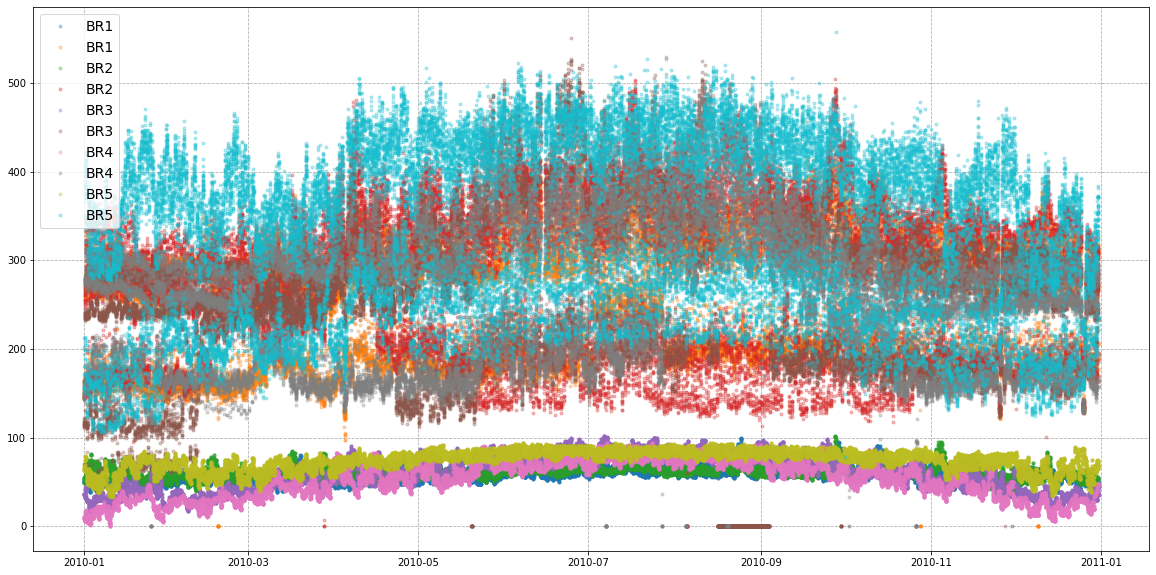

In [4]:
# Una grafico para visualizar el comportamiento de los datos
fig1, ax1 = plt.subplots(figsize=(20,10))
for i in range(len(pieces)):
    ax1.plot(pieces[i], marker='.', linestyle="None", alpha=0.3, label=(labels[i]))
    
plt.legend(fontsize=14)
plt.grid(linestyle='dashed')
plt.savefig("BR1.png",dpi=100, facecolor='w', edgecolor='w')

<AxesSubplot:xlabel='Timestamp'>

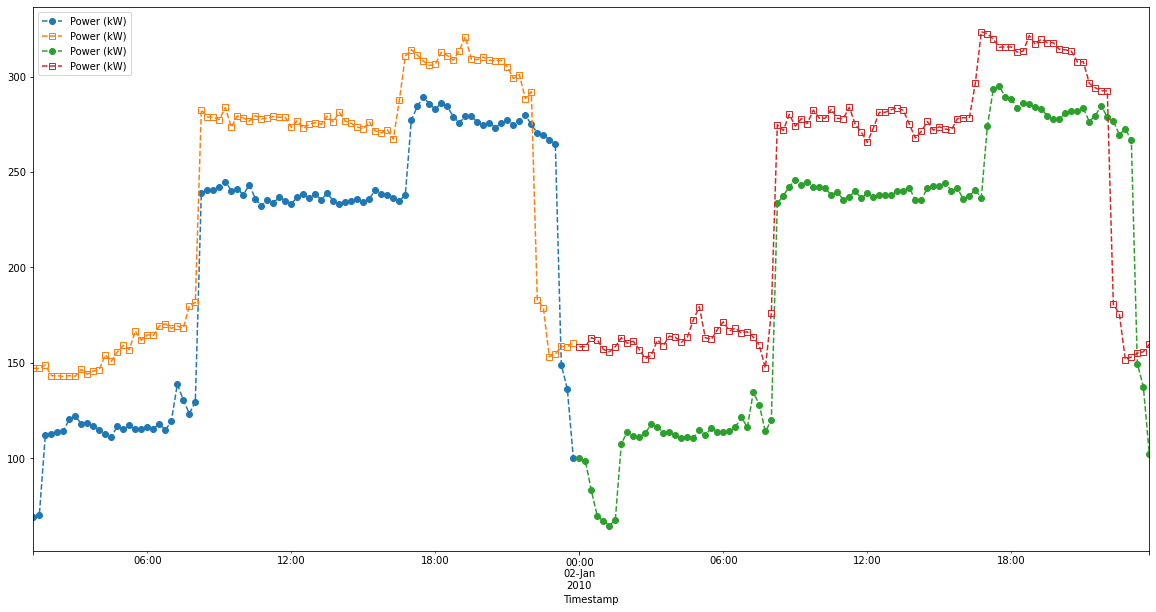

In [5]:
# Una segunda grafica que muestra mejor el comportamiento de la potencia medida a lo largo del dia.
fig4, ax4 = plt.subplots(figsize=(20,10))
df3.loc['2010-01-01', ['Power (kW)']].plot(marker='o', linestyle="dashed",ax=ax4)
df4.loc['2010-01-01', ['Power (kW)']].plot(marker='s',markerfacecolor='None', linestyle="dashed",ax=ax4)

df3.loc['2010-01-02', ['Power (kW)']].plot(marker='o', linestyle="dashed",ax=ax4)
df4.loc['2010-01-02', ['Power (kW)']].plot(marker='s', markerfacecolor='None', linestyle="dashed",ax=ax4)

Revisar las propiedades de los datos. Especificamente revisamos si hay valores faltantes.

In [6]:
df_concat.isnull().values.any()

False

por lo tanto concluimos que no hay valores faltantes

¿Cuál es el comportamiento de los datos?

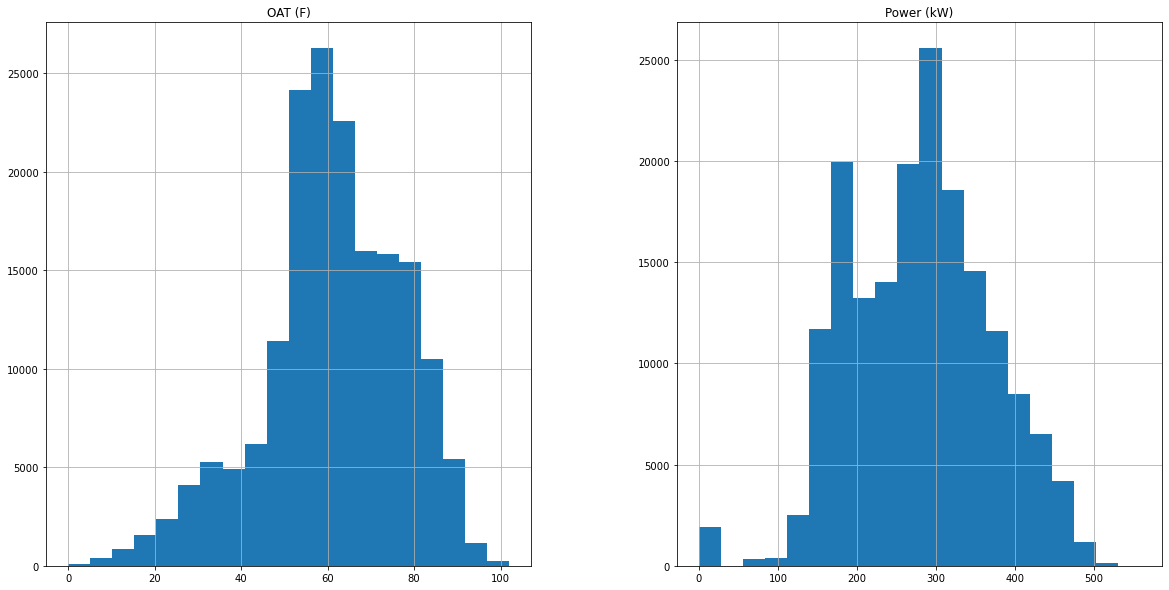

In [7]:
df_concat.hist(bins=20, figsize=(20,10))
plt.savefig("BR1_hist", dpi=100, facecolor='w', edgecolor='w')

<AxesSubplot:>

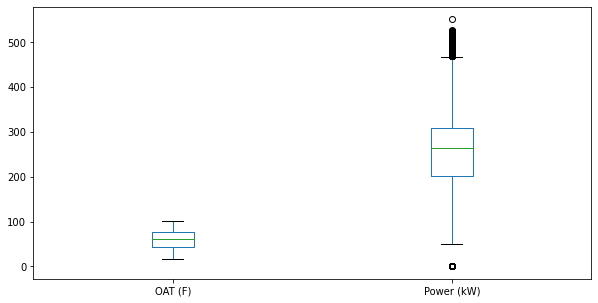

In [8]:
df3.plot(kind='box', figsize=(10,5))

Vamos a limpiar nuestros datos usando el **zscore**. 

$$
z = \frac{x-\mu}{\sigma}
$$

De las gráficas notamos que hay valores de potencia que son muy cercanos a cero, o que son exactamente cero. Estos valores serán descartados.
Un método para esto sería descartando los valores que tienen __zscore__ mayores a al zscore de un valor teórico igual a cero. Es decir:

In [9]:
mean_Power = df_concat['Power (kW)'].mean()
std_Power = df_concat['Power (kW)'].std()
z0 = mean_Power/std_Power
print("zscore de un valor teórico igual a cero z0 =",z0)

zscore de un valor teórico igual a cero z0 = 3.132331309970334


Ahora, cualquier valor con zscore mayor o igual $z_0$ será descartado como se sigue:

In [10]:
std_dev = z0
df_outliersz = df_concat.loc[(np.abs(stats.zscore(df_concat)) > 2).any(axis=1)]
df_cleanz = df_concat.loc[~(np.abs(stats.zscore(df_concat)) > 2).any(axis=1)]
df_outliersz

,OAT (F),Power (kW)
Timestamp,,
2010-02-18 00:00:00,55,0.0
2010-02-18 00:15:00,54,0.0
2010-02-18 00:30:00,54,0.0
2010-02-18 00:45:00,54,0.0
2010-02-18 01:00:00,54,0.0
...,...,...
2010-11-27 19:00:00,74,461.2
2010-11-27 19:45:00,73,464.1
2010-11-27 20:00:00,73,470.4


El inconvenitente con ese método, es que también son descartados valores que no son necesariamente cero, sino que están por fuera de $z_0 = 3.1323$ desviaciones estándar.

Otra forma es eliminar directamente las filas que tienen valores cero en la columna de potencia; como se sigue:

In [11]:
df_clean0 = df_concat.loc[~(df_concat == 0).any(axis=1)]
df_outliers0 = df_concat.loc[(df_concat == 0).any(axis=1)]
df_outliers0

,OAT (F),Power (kW)
Timestamp,,
2010-02-18 00:00:00,55,0.0
2010-02-18 00:15:00,54,0.0
2010-02-18 00:30:00,54,0.0
2010-02-18 00:45:00,54,0.0
2010-02-18 01:00:00,54,0.0
...,...,...
2010-10-26 14:30:00,59,0.0
2010-10-26 14:45:00,59,0.0
2010-10-26 15:00:00,59,0.0


In [12]:
# Creo un pequeño switch para comparar cómo el método de limpieza cambia el comportamiento del modelo.
# 1 para usar el método de < z_0 = 2.0
# cualquier otro para usar el método de valores iguales a cero.

def Switch(bit):
    if bit == 1:
        print("Método de < z_0 = 2.0")
        df_c = df_cleanz
        outliers = df_outliersz
    else:
        print("Método de valores iguales a cero")
        df_c = df_clean0
        outliers = df_outliers0
    return df_c, outliers

df_clean, df_outliers = Switch(0)
# Lo mejor es dejar el Switch en bit = 0, los datos se filtran de una forma que no es deseada con el método de de < z_0 = 2.0

Método de valores iguales a cero


<AxesSubplot:xlabel='Timestamp'>

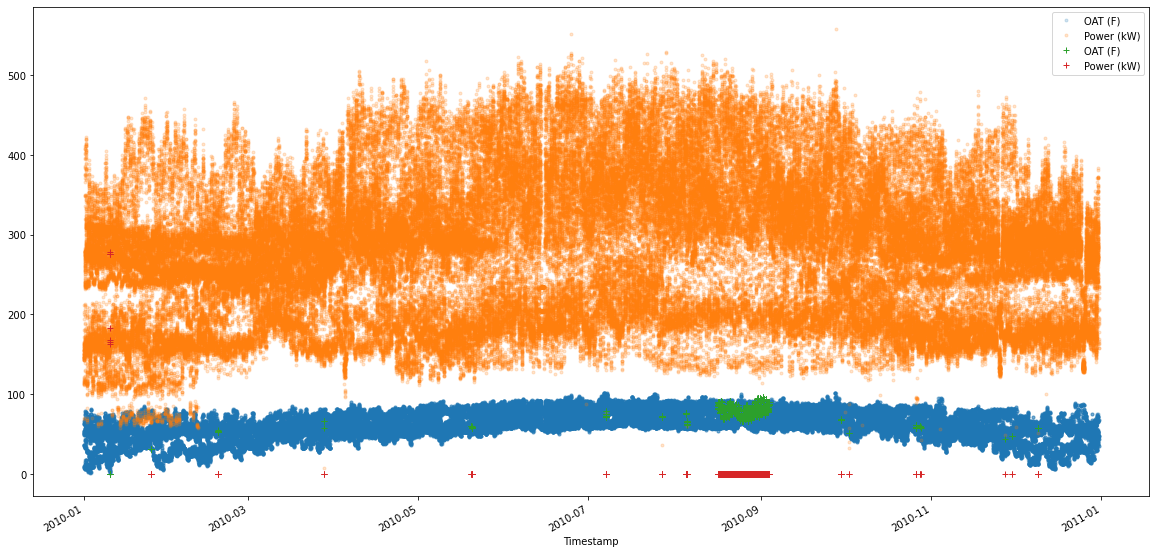

In [13]:
fig1, ax = plt.subplots(figsize=(20,10))
plt.title("")
df_clean.plot(marker='.', linestyle="None", ax=ax, alpha=0.2)
df_outliers.plot(marker='+', linestyle="None", ax=ax)

Text(0.5, 1.0, 'Dataframe without 0 values')

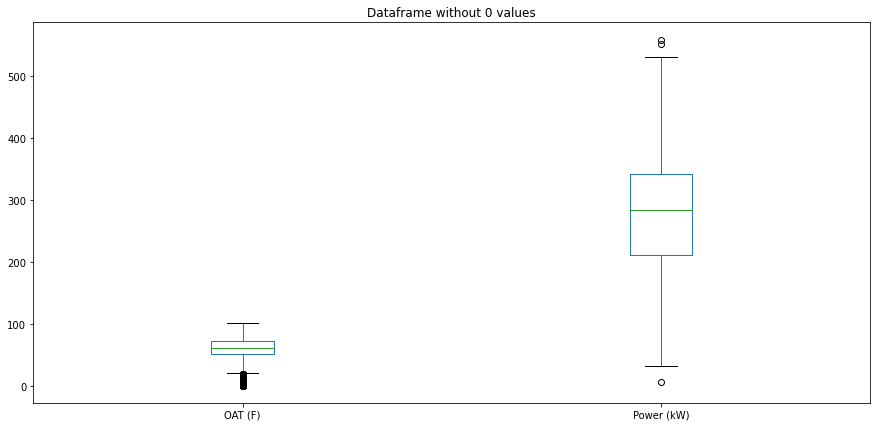

In [14]:
fig23, ax23 = plt.subplots(figsize=(15,7))
#df_clean.plot(kind='box', ax=ax23)
df_clean.plot(kind='box', ax=ax23)
plt.title("Dataframe without 0 values")

Ahora nos disponemos a crear el primer modelo lineal de los datos.

Como primera aproximación, se considera una correlación entre la **Temperatura** y la **Potencia**

# Regresión Lineal

In [15]:
X1 = pd.DataFrame(df_clean['OAT (F)'])
Y1 = pd.DataFrame(df_clean['Power (kW)'])

linear_regression = LinearRegression()
linear_regression.fit(X1,Y1)

LinearRegression()

In [16]:
print("pendiente, intercepto",linear_regression.coef_, linear_regression.intercept_) 
print("Formas de X y Y", X1.values.flatten().shape, Y1.values.flatten().shape)

pendiente, intercepto [[3.04731005]] [97.52190825]
Formas de X y Y (172785,) (172785,)


Text(0.5, 0, 'OAT [F]')

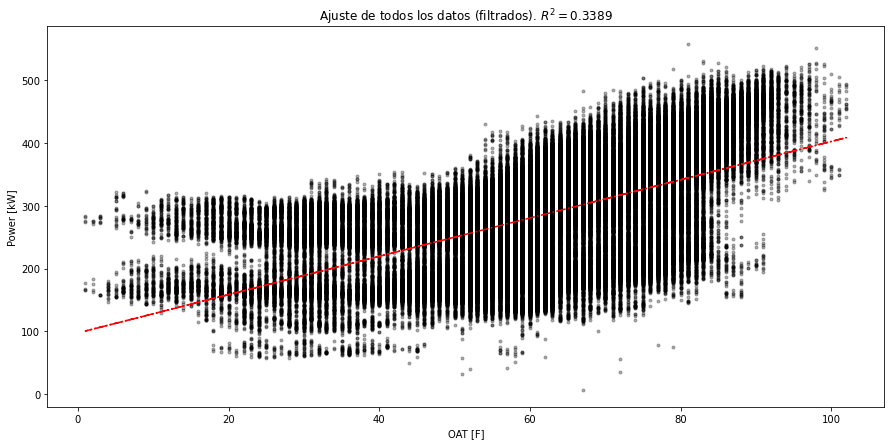

In [17]:
Y1_pred = linear_regression.intercept_[0] + linear_regression.coef_[0][0] * X1.values.flatten()
R2_pred = linear_regression.score(X1,Y1)

fig24, ax24 = plt.subplots(figsize=(15,7))
plt.title("Ajuste de todos los datos (filtrados). $R^2 = ${0:3.4f}".format(R2_pred))
ax24.plot(X1.values.flatten(),Y1.values.flatten(),'k.', alpha=0.3) # Datos
ax24.plot(X1.values.flatten(), Y1_pred, '-.r') # Recta

ax24.set_ylabel("Power [kW]")
ax24.set_xlabel("OAT [F]")

In [18]:
# Crea un arreglo para el entrenamiento de la regresión usando el 33% de los datos del dataframe.
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size=0.33, random_state=20)

In [19]:
Coef = LinearRegression().fit(X1_train, Y1_train) 
# Esta es la forma en cómo se usa LinearRegression. Hay que llamar uno de sus métodos: 
# fit(X, y[, sample_weight]), get_params([deep]), predict(X), score(X, y[, sample_weight]), set_params(**params)
# LinearRegression devuelve una instancia de símisma, entonces para saber lo que devuelve tengo que hacer, en el caso de fit(): 
# LinearRegression().coef_ o  LinearRegression().intercept_ llamar los atributos
# En este caso, LinearRegression() = Coef, luego:
print(Coef.coef_, Coef.intercept_)

[[3.05323784]] [97.16377471]


In [20]:
R2_test = Coef.score(X1_test,Y1_test) # Calculo R^2 del conjunto de X,Y_Test usando los parametros de la regresión
# Recordando que linear_regressión (Coef) tiene en símimos estos coeficientes.
print("El socre con los datos de prueba es: ",R2_test)

El socre con los datos de prueba es:  0.3378323611452011


Como vemos, el resultado no es muy bueno y el resultado es el mismo que cuando se usaron todos los datos.
A continuación, se grafica la recta de mejor ajuste y los datos de prueba (test).

Text(0.5, 0, 'OAT [F]')

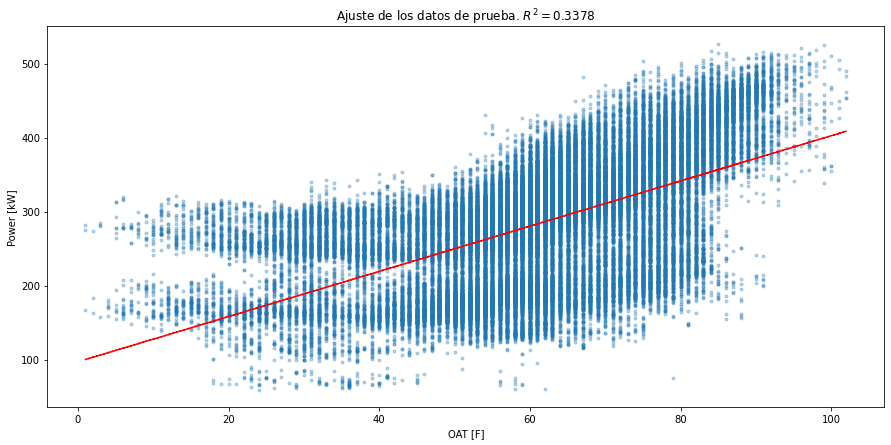

In [21]:
Y1_test_pred = Coef.intercept_[0] + Coef.coef_[0][0] * X1_test.values.flatten()

fig25, ax25 = plt.subplots(figsize=(15,7))

plt.title("Ajuste de los datos de prueba. $R^2 = ${0:3.4f}".format(R2_test))
ax25.plot(X1_test.values.flatten(),Y1_test.values.flatten(),'.', alpha=0.3) # datos
ax25.plot(X1_test.values.flatten(), Y1_test_pred, '-.r') # recta

ax25.set_ylabel("Power [kW]")
ax25.set_xlabel("OAT [F]")

## Continuando con regresión lineal
- adición de características
- colinealidad
- características cualitativas
- precisión del modelo

Nos damos cuenta que para el modelo puede ser valioso conocer "la hora". Agreguemos entonces la hora como predictor a nuestro modelo

In [22]:
#df_clean['hour']=df_clean.index.hour
df_p = df_clean # df_p: dataframe plus, aumentado con la hora
df_p.loc[:,"Hour"] = df_clean.index.hour
df_p

C:\Users\Admin\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\Admin\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,OAT (F),Power (kW),Hour
Timestamp,,,
2010-01-01 01:15:00,51,165.1,1
2010-01-01 01:30:00,51,151.6,1
2010-01-01 01:45:00,51,146.9,1
2010-01-01 02:00:00,51,153.7,2
2010-01-01 02:15:00,51,153.8,2
...,...,...,...
2010-12-30 23:00:00,67,333.7,23
2010-12-30 23:15:00,68,221.0,23
2010-12-30 23:30:00,68,235.7,23


Definimos de nuevo nuestra matriz de datos $X$ y el vector de resultados $y$

In [23]:
X2 = pd.DataFrame(df_p[['OAT (F)','Hour']]) # Ahora tiene una dimension extra.
Y2 = pd.DataFrame(df_p['Power (kW)'])

In [24]:
# Creamos el conjunto de datos de entrenamiento
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size=0.33, random_state=20)

In [25]:
# Obtenemos el ajuste
betas_p = LinearRegression().fit(X2_train,Y2_train)
print("Coeficientes:", betas_p.coef_, betas_p.intercept_)
print("Score: ",betas_p.score(X2_test, Y2_test))

Coeficientes: [[2.68100253 6.10280063]] [49.65254741]
Score:  0.5780136110430558


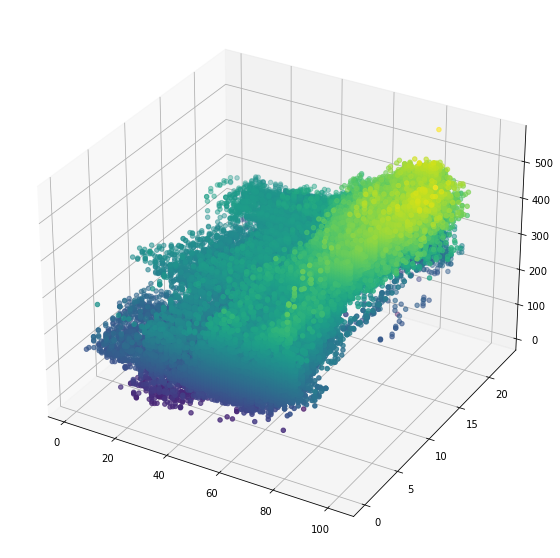

In [26]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X2_train['OAT (F)'], X2_train['Hour'], Y2_train, c=Y2_train, cmap='viridis')

Vamos a crear una característica cualitativa relacionada con el estado de las tiendas: abierto o cerrado.
Asumimos que si la tienda está abierta la nueva característica tendrá un valor de 1, de lo contrario será 0

El horario de servicio los tomamos como de **08:00** a **21:00** 

In [27]:
df_pp = df_p
df_pp['open_hours'] = np.where((df_p.index.hour >= 8) & (df_p.index.hour <= 21),1,0) # Basta con hacer una mejor estimación de este atributo
# para obtener un mejor modelo, como se explica más abajo.

<ipython-input-27-13b9ffeffd17>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pp['open_hours'] = np.where((df_p.index.hour >= 8) & (df_p.index.hour <= 21),1,0) # Basta con hacer una mejor estimación de este atributo


In [28]:
df_pp.sample(10)

,OAT (F),Power (kW),Hour,open_hours
Timestamp,,,,
2010-07-14 03:15:00,75,198.1,3,0
2010-07-21 02:15:00,62,146.8,2,0
2010-11-17 09:30:00,77,400.6,9,1
2010-02-28 00:45:00,50,161.3,0,0
2010-09-28 14:00:00,80,355.9,14,1
2010-09-19 03:30:00,57,153.8,3,0
2010-04-26 06:15:00,78,361.5,6,0
2010-07-25 12:30:00,66,323.1,12,1
2010-06-26 18:30:00,67,318.8,18,1


In [29]:
X3 = pd.DataFrame(df_pp[['OAT (F)','open_hours', 'Hour']])
Y3 = pd.DataFrame(df_pp['Power (kW)'])

X3_train, X3_test, Y3_train, Y3_test = train_test_split(X3, Y3, test_size=0.33, random_state=33)

betas_pp = LinearRegression().fit(X3_train, Y3_train) 

print("R2 Score para los datos con atributo de 'hora de apertura' y 'hora':",betas_pp.score(X3_test, Y3_test))

R2 Score para los datos con atributo de 'hora de apertura' y 'hora': 0.7129305691085337


Algo muy interesante a considerar es por ejemplo, cuando se asume que la hora de apertura es a las **9 a.m** el score de $R^2$ da como resultado 
$R^2 = 0.69462$. Por otro lado, cuando se usa la hora de apertura de **8 a.m**, que parece ser la hora real a la que entran en actividad los 5 edificios, el score da $R^2 = 0.71293$. Así que cuando los parámetros con los que se definen los atributos cualitativos son los más cercanos a la realidad, se obtiene como resultado un mejor comportamiento del modelo.

Ahora vamos a agregar otro aspecto cualitativo de los datos, y es que hay un rango en el día en donde la temperatura externa medida empiece a crecer, que corresponde a las **06:00** horas del día donde el Sol está afuera y tiene su mayor influencia en la temperatura local.
Así que consideramos que la hora en la que empiza aumentar la temperatura es a las **06:00**, para alcanzar su máximo alrededor de las **14:00** y para luego tener su mínimo a las **06:00** del dia siguiente. Por lo tanto, podemos definir el día y la noche en función de la temperatura del día, aunque así no lo sea físicamente, puede que el Sol ya se haya puesto y aún así la temperatura no haya alcanzado su máximo. Entonces definimos el día-temperatura así:

**Es de día cuando la temperatura esta subiendo, y es de noche cuando está bajando.**

A continuación una gráfica que nos perminte visualizar lo anterior.

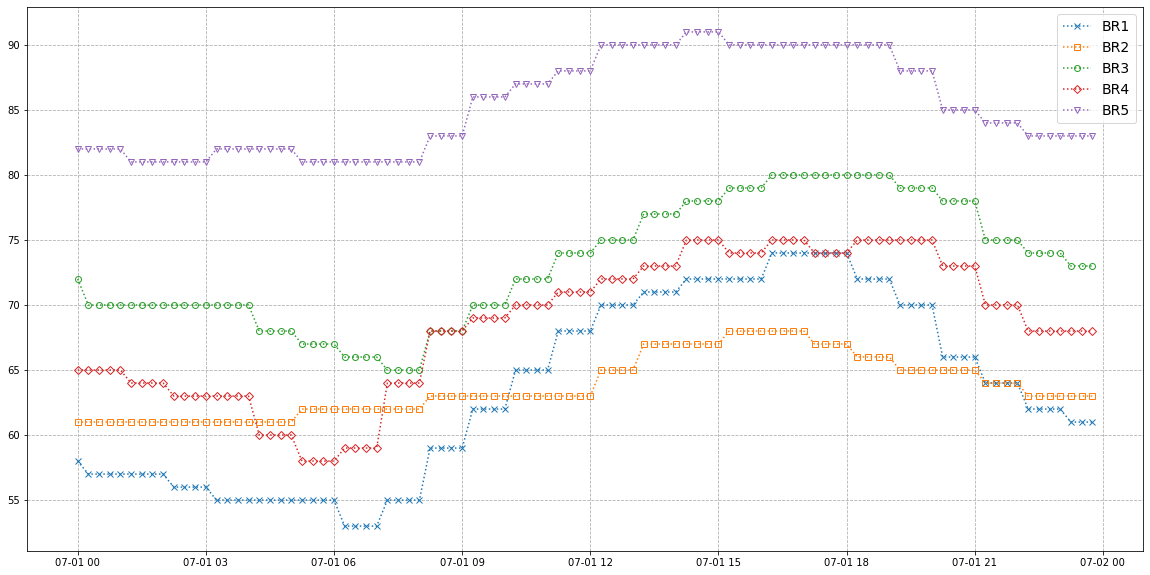

In [73]:
mark = ['x', 's', 'o', 'D', 'v']
color = ['k', 'r', 'g', 'b', 'purple']
fig7, ax7 = plt.subplots(figsize=(20,10))
#:'2010-10-06'
for i in range(len(pieces)):    
    ax7.plot(pieces[i].loc['2010-07-01', ['OAT (F)']], marker=mark[i],
                                                         linestyle="dotted",
                                                         markerfacecolor='None',
                                                         label=(labels[i]))
    
plt.legend(fontsize=14)
plt.grid(linestyle='dashed')
#plt.savefig("BRall.png",dpi=100, facecolor='w', edgecolor='w')

In [ ]:
df_pp.loc['2010-07-01',['OAT (F)']].max
df_ppp = df_pp
df_ppp['Day?'] = np.where((df_pp.index.hour >= 6) & (df_pp.index.hour <= 12),1,0) 
df_ppp.sample(10)

In [69]:
X4 = pd.DataFrame(df_ppp[['OAT (F)','open_hours', 'Hour', 'Day?']])
Y4 = pd.DataFrame(df_ppp[['Power (kW)']])

In [70]:
X4_train, X4_test, Y4_train, Y4_test = train_test_split(X4, Y4, test_size=0.33, random_state=33)

betas_ppp = LinearRegression().fit(X4_train, Y4_train) 

print("R2 Score para los datos con atributo de 'hora de apertura', 'hora' y 'dia?':",betas_ppp.score(X4_test, Y4_test))

R2 Score para los datos con atributo de 'hora de apertura', 'hora' y 'dia?': 0.7129045440292948


Lastimosamente esto no parece funcionar porque el R2 score disminuyó.